# Plate Generator Notebook
### This notebook will demonstrate and execute the generation of synthetic license plates

In [35]:
# We will begin by importing necessary modules

import os
import random
from PIL import Image, ImageDraw, ImageFont, ImageFilter, ImageChops, ImageOps
import numpy as np
import matplotlib.pyplot as plt
import math
import cv2
import qrcode
import uuid
import random
import string
from PIL import Image

# Since we will be generating this on Google Colab, let's define the paths for our assets as well to make changing these later on easier.

documentation_dir = "documentation"
fonts_dir = "fonts"
images_dir = "images"

The generation process begins with selecting the style for the plate, including color palette and plate background.
We will be basing our choices on the Wikipedia page on Philippine License Plates: https://en.wikipedia.org/wiki/Vehicle_registration_plates_of_the_Philippines.

<figure>
  <img src="documentation/philippine_license_plates.jpg" alt="Philippine License Plates Color Palettes" width="300" />
  <figcaption>Fig 1. Philippine License Plates Color Palettes</figcaption>
</figure>

<figure>
  <img src="documentation/private_passenger_plates.jpg" alt="Private and Passenger License Plates" width="300" />
  <figcaption>Fig 2. Private and Passenger License Plates</figcaption>
</figure>

## Plate Styles
### Plates follow certain formats and color palettes. For the generation step later, it will be useful to have these gathered as one array so we can randomly choose.

In [36]:
# The plate generation process starts by selecting a style for our plates.
# This block defines the various styles that a license plate may have.

# DEFAULT COLORS --------------------------------
# general
black = (0, 0, 0)
white = (255, 255, 255)
# vehicles
v_green = (3, 105, 55)
v_yellow = (246, 196, 13)
v_red = (249, 0, 0)
v_maroon = (134, 0, 0)
v_blue = (6, 41, 100)
# motorcycles
m_pink = (201, 100, 206)
m_green = (0, 123, 95)
m_gray = (119, 111, 103)
m_sky_blue = (106, 179, 230)
m_dark_blue = (47, 0, 140)
m_orange = (227, 82, 5)
m_red = (200, 16, 46)
m_brown = (139, 56, 26)
# government
g_blue = (10, 71, 173)
# rizal background (special case)
r_green = (21, 109, 82)
r_background = os.path.join(images_dir, "plate_backgrounds", "rizal.png")

# LICENSE PLATE STYLES --------------------------------
plate_styles = [
    # type, color1, color2
    ("vehicle", white, black),
    ("vehicle", white, v_green),
    ("vehicle", v_yellow, black),
    ("vehicle", white, v_red),
    ("vehicle", white, v_blue),
    ("motorcycle", white, black),
    ("motorcycle", white, m_pink),
    ("motorcycle", white, m_green),
    ("motorcycle", white, m_gray),
    ("motorcycle", white, m_sky_blue),
    ("motorcycle", white, m_dark_blue),
    ("motorcycle", white, m_orange),
    ("motorcycle", white, m_red),
    ("motorcycle", white, m_brown),
    ("government", g_blue, black),
    ("motorcycle_beveled", white, black),
    ("motorcycle_beveled", v_yellow, black),
    ("motorcycle_beveled", white, v_maroon),
    ("rizal", None, r_green),
]


## Plate Base
### This block creates the base for our plates without the text and obscurations.

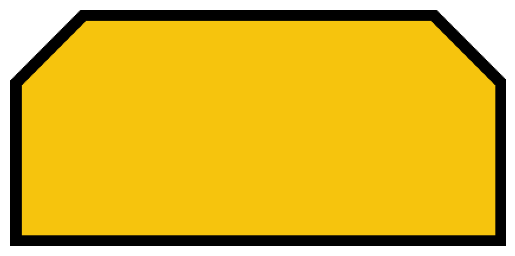

In [37]:
# Next, we will define the function that creates the base for our plates

# scale for debugging
debug_scale = 2
# vehicle
vw, vh = 280*debug_scale, 100*debug_scale
# motorcycle
mw, mh = 175*debug_scale, 100*debug_scale
# motorcycle beveled
maw, mah = 210*debug_scale, 100*debug_scale
corner = 30*debug_scale

def create_plate_base(width, height, border_color, fill_color, border_thickness=5, has_bevel=False):
    img = Image.new('RGBA', (width, height), (0, 0, 0, 0))
    draw = ImageDraw.Draw(img)
    
    b_color = border_color + (255,)
    f_color = fill_color + (255,)
    bt = border_thickness*debug_scale

    if has_bevel:
        # Calculate offset to keep visual thickness uniform on diagonal
        # Math: The shift along the axis = bt * (sqrt(2) - 1)
        shift = int(bt * (math.sqrt(2) - 1))
        
        # 1. Outer Polygon
        outer_points = [
            (0, corner),                # TL Bevel Start
            (corner, 0),                # TL Bevel End
            (width - corner, 0),        # TR Bevel Start
            (width, corner),            # TR Bevel End
            (width, height),            # BR
            (0, height)                 # BL
        ]
        
        # 2. Inner Polygon
        # We inset by 'bt' for straights, and 'corner + shift' for bevel intersections
        inner_points = [
            (bt, corner + shift),               
            (corner + shift, bt),               
            (width - corner - shift, bt),       
            (width - bt, corner + shift),       
            (width - bt, height - bt),          
            (bt, height - bt)                   
        ]
        
    else:
        # Standard Rectangle
        outer_points = [
            (0, 0), (width, 0), (width, height), (0, height)
        ]
        inner_points = [
            (bt, bt), (width - bt, bt), (width - bt, height - bt), (bt, height - bt)
        ]

    draw.polygon(outer_points, fill=b_color)
    draw.polygon(inner_points, fill=f_color)

    return img

def plot_image(img):
    if img.mode == 'L':
        plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    else:
        plt.imshow(img)
    plt.axis('off')
    plt.show()
    
plot_image(create_plate_base(maw, mah, black, v_yellow, has_bevel=True))

## Text Layer
For later annotation, taking note of the letter positions will become extremely important. We'll take note of the letter segments in this implementation.

To start, we'll set up our fonts and scaling utilities.

In [38]:
# Let's define our fonts first

fonts = [
    os.path.join(fonts_dir, f)
    for f in os.listdir(fonts_dir)
    if f.lower().endswith((".ttf", ".otf"))
]

from PIL import Image, ImageDraw, ImageFont

font_scaling = 0.92

Because we want our text to fit nicely within the plate dimensions, we will create a utility function that scales the font size accordingly.

The plan later on is to manipulate the letters as bitmap masks, hence the implementation shown here.


In [39]:
def get_scaled_font(draw, font_path, text, width, height, initial_size=10, step=2):
    """
    Returns the scaled ImageFont object that fits within width/height constraints.
    """
    max_width, max_height = width * font_scaling, height * font_scaling
    size = initial_size

    while True:
        font_obj = ImageFont.truetype(font_path, size)
        bbox = draw.textbbox((0, 0), text, font=font_obj)
        w, h = bbox[2] - bbox[0], bbox[3] - bbox[1]

        if w > max_width or h > max_height:
            break
        size += step

    return ImageFont.truetype(font_path, size - step)


The reason I approached the plate text on a letter-by-letter basis was because we can just convert these into polygons later on.

I've prepared assets to simulate paint chipping, found in images\obscurations_letter. So I also need a method that applies these masks onto an individual letter image.

In [40]:
# polygon from mask

def get_polygon_from_mask(mask):
    mask_array = np.array(mask)

    contours, _ = cv2.findContours(
        mask_array,
        cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE
    )

    polygons = []
    for cnt in contours:
        if cv2.contourArea(cnt) > 1:  # ignore tiny specks
            poly_points = cnt.reshape(-1, 2).tolist()
            polygons.append(poly_points)

    return polygons

# paint chipping config

chip_dir = os.path.join(images_dir, "obscurations_letter")

chip_mask_files = [
    os.path.join(chip_dir, f)
    for f in os.listdir(chip_dir)
    if f.lower().endswith((".png", ".jpg"))
]

chipping_probability = 0.5


In [41]:
# paint chipping function

def apply_paint_chipping(letter_image, letter_mask):
    # Only apply chipping with configured probability
    if random.random() > chipping_probability:
        return letter_image

    bbox = letter_mask.getbbox()
    if not bbox:
        return letter_image  # No letter found in mask

    chip_mask_path = random.choice(chip_mask_files)
    chip_mask = Image.open(chip_mask_path).convert("L")

    letter_width = bbox[2] - bbox[0]
    letter_height = bbox[3] - bbox[1]

    # Resize chip mask to relative size
    scale_factor = random.uniform(0.3, 0.7)
    chip_width = int(letter_width * scale_factor)
    chip_height = int(letter_height * scale_factor)

    chip_mask = chip_mask.resize((chip_width, chip_height), Image.Resampling.LANCZOS)

    placement_mask = Image.new("L", letter_image.size, 0)

    max_x = bbox[0] + letter_width - chip_width
    max_y = bbox[1] + letter_height - chip_height

    if max_x <= bbox[0] or max_y <= bbox[1]:
        return letter_image  # Letter too small for chipping

    pos_x = random.randint(bbox[0], max_x)
    pos_y = random.randint(bbox[1], max_y)

    placement_mask.paste(chip_mask, (pos_x, pos_y))

    # Apply chipping by changing alpha where placement mask is white
    text_layer_rgba = letter_image.convert("RGBA")

    alpha = text_layer_rgba.split()[3]
    alpha_array = np.array(alpha)
    chip_array = np.array(placement_mask)

    alpha_array[chip_array > 128] = 0

    new_alpha = Image.fromarray(alpha_array)
    r, g, b, _ = text_layer_rgba.split()
    result = Image.merge("RGBA", (r, g, b, new_alpha))

    return result


Now, I can create the actual text layer. 
The paint chipping allows for letter-level obscurations.
The polygon annotation will help verifying the bitmap masks' locations.

In [42]:
def create_text_layer(font_path, text, width, height, fill_color, enable_paint_chipping=False):
    """
    Draws each letter individually and returns:
      { "image": Image(RGBA), "annotations": [ {"character": char, "mask": Image(L)} ... ] }
    """
    text_layer = Image.new("RGBA", (width, height), (0, 0, 0, 0))
    d = ImageDraw.Draw(text_layer)

    # Get scaled font for the full text block
    font_obj = get_scaled_font(d, font_path, text, width, height)

    full_bbox = d.textbbox((0, 0), text, font=font_obj)
    total_w = full_bbox[2] - full_bbox[0]
    total_h = full_bbox[3] - full_bbox[1]

    current_x = (width - total_w) // 2
    y_pos = (height - total_h) // 2 - full_bbox[1]

    letter_bitmap_annotations = []

    for char in text:
        # A. create per-char mask
        char_mask = Image.new("L", (width, height), 0)
        mask_d = ImageDraw.Draw(char_mask)
        mask_d.text((current_x, y_pos), char, font=font_obj, fill=255)
        letter_bitmap_annotations.append({"character": char, "mask": char_mask})

        # B. draw visible letter on the main layer
        d.text((current_x, y_pos), char, font=font_obj, fill=fill_color + (255,))

        # C. advance cursor
        char_width = d.textlength(char, font=font_obj)
        current_x += char_width

    # Apply paint chipping per letter if requested
    if enable_paint_chipping:
        for annotation in letter_bitmap_annotations:
            text_layer = apply_paint_chipping(text_layer, annotation["mask"])

    return {"image": text_layer, "annotations": letter_bitmap_annotations}


Here is what the base text looks like without chipping.

Base Text Rendering (no chipping)


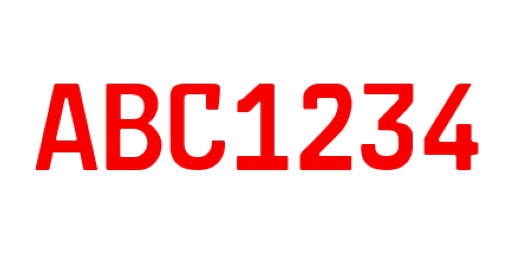

In [43]:
# Cell 7 — Base rendering display (no chipping)
print("Base Text Rendering (no chipping)")
base_text = create_text_layer(
    fonts[0],
    "ABC1234",
    maw,
    mah,
    v_red,
    enable_paint_chipping=False
)
plot_image(base_text["image"])

Now, let's see the per-character masks (or the bitmap masks which we'll convert into annotations later on).

Character Bitmap Annotations
character: A


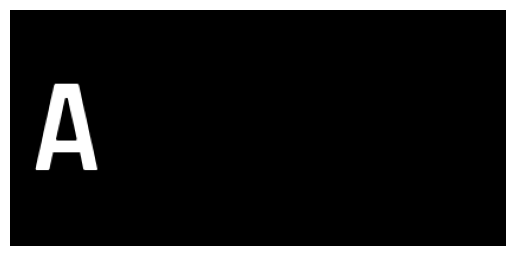

character: B


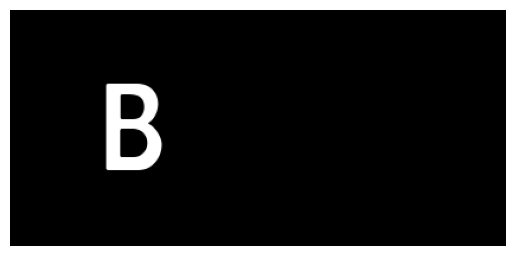

character: C


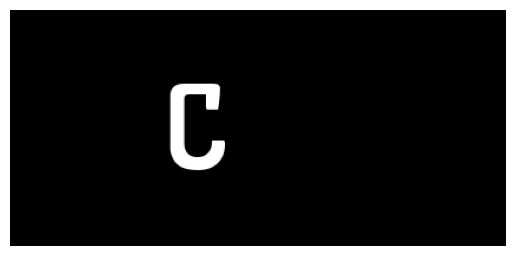

character: 1


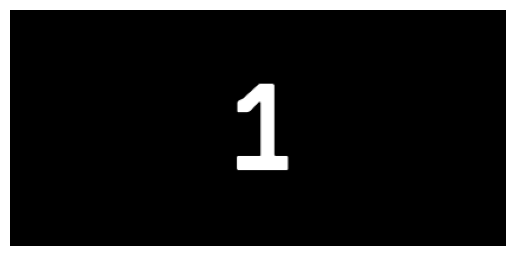

character: 2


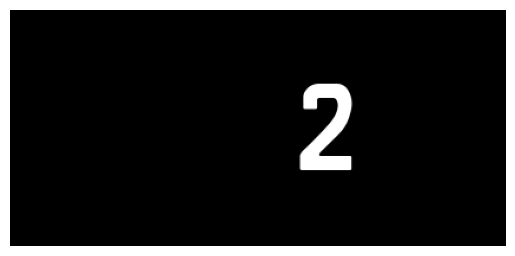

character: 3


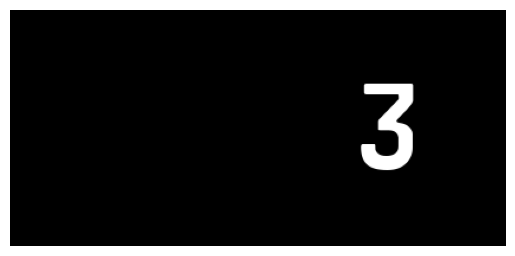

character: 4


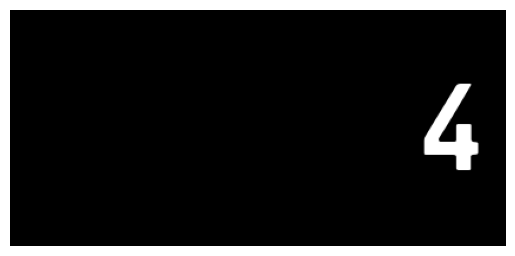

In [44]:
print("Character Bitmap Annotations")
for annotation in base_text["annotations"]:
    print("character:", annotation["character"])
    plot_image(annotation["mask"])

And here's what a license plate looks like with paint chipping.

Text Rendering with Paint Chipping


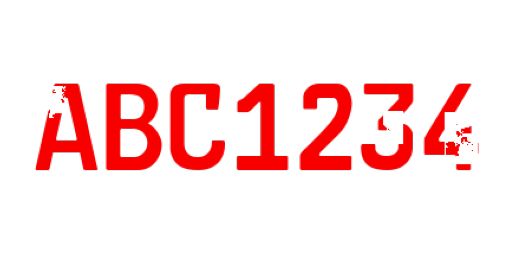

In [45]:
print("Text Rendering with Paint Chipping")
chipped_text = create_text_layer(
    fonts[0],
    "ABC1234",
    maw,
    mah,
    v_red,
    enable_paint_chipping=True
)
plot_image(chipped_text["image"])


Now I'll create the polygon conversion and visualization methods.
I'll be affining and transforming these text layers. It's helpful to verify if the annotations are still correct.

Text Layer with Annotation Polygons (chipped)


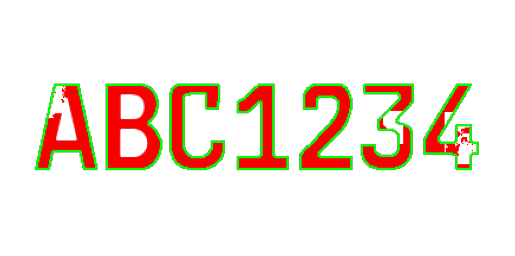

In [46]:
def convert_to_polygons(annotations):
    all_polygons = []
    for annotation in annotations:
        polygons = get_polygon_from_mask(annotation["mask"])
        all_polygons.extend(polygons)
    return all_polygons

def visualize_polygon_overlay(original_image, annotations):
    debug_img = original_image.convert("RGBA").copy()
    all_polygons = convert_to_polygons(annotations)
    d = ImageDraw.Draw(debug_img)
    for poly in all_polygons:
        if not poly:
            continue
        poly_tuples = [tuple(point) for point in poly]
        d.polygon(poly_tuples, outline=(0, 255, 0, 255), width=2)
    return debug_img

print("Text Layer with Annotation Polygons (chipped)")
overlay_img = visualize_polygon_overlay(chipped_text["image"], chipped_text["annotations"])
plot_image(overlay_img)


## Content Layer
### The content layer involves the text layer, but also has a border and smaller text. Emboss is added to enhance realism.
### The border will be added at the template level, so let's focus on the emboss and small text.

Let's start off by defining our emboss utility function.

In [53]:
def apply_random_emboss(layer: Image.Image) -> Image.Image:
    if layer.mode != "RGBA":
        layer = layer.convert("RGBA")

    w, h = layer.size
    alpha = layer.split()[3]

    blur_radius = random.uniform(0.05, 0.3)
    heightmap = alpha.filter(ImageFilter.GaussianBlur(blur_radius))

    angle = random.uniform(0, 2 * math.pi)
    strength = random.uniform(0, 3.5)

    if strength < 0.1:
        return layer

    dx = int(round(math.cos(angle) * strength))
    dy = int(round(-math.sin(angle) * strength))

    light_shift = ImageChops.offset(heightmap, -dx, -dy)
    dark_shift = ImageChops.offset(heightmap, dx, dy)

    highlight = ImageChops.subtract(light_shift, heightmap)
    shadow = ImageChops.subtract(dark_shift, heightmap)

    highlight_strength = random.uniform(1.2, 1.6)
    shadow_strength = random.uniform(0.8, 1.1)

    highlight = highlight.point(lambda p: int(min(255, p * highlight_strength)))
    shadow = shadow.point(lambda p: int(min(255, p * shadow_strength)))

    highlight_col = Image.new("RGBA", (w, h), (255, 255, 255, 0))
    highlight_col.putalpha(highlight)

    shadow_col = Image.new("RGBA", (w, h), (0, 0, 0, 0))
    shadow_col.putalpha(shadow)

    out = Image.alpha_composite(layer, highlight_col)
    out = Image.alpha_composite(out, shadow_col)

    return out


Now a few more auxiliary text helpers.

In [54]:
def generate_dummy_text():
    words = []
    for _ in range(3):
        length = random.randint(3, 5)
        word = ''.join(random.choices(string.ascii_uppercase + string.digits, k=length))
        words.append(word)
    return " ".join(words)

def add_small_text(plate_image, text, position="bottom", font_path=None, color=None):
    if plate_image.mode != "RGBA":
        plate_image = plate_image.convert("RGBA")

    result = plate_image.copy()
    draw = ImageDraw.Draw(result)

    width, height = plate_image.size
    if font_path is None and fonts:
        font_path = random.choice(fonts)

    if position == "bottom":
        max_text_width = int(width * 0.9)
        max_text_height = int(height * 0.15)
        text_x = width // 2
        text_y = height - int(height * 0.05)
    elif position == "top":
        max_text_width = int(width * 0.9)
        max_text_height = int(height * 0.15)
        text_x = width // 2
        text_y = int(height * 0.3)
    else:
        return plate_image

    small_font = get_scaled_font(
        draw, font_path, text,
        max_text_width, max_text_height,
        initial_size=10, step=2
    )

    text_layer = Image.new("RGBA", (width, height), (0, 0, 0, 0))
    td = ImageDraw.Draw(text_layer)
    td.text((text_x, text_y), text, font=small_font, fill=color + (255,), anchor="ms")

    text_layer = apply_random_emboss(text_layer)
    return Image.alpha_composite(result, text_layer)


Emboss Effect Demo

Text with Random Emboss Applied


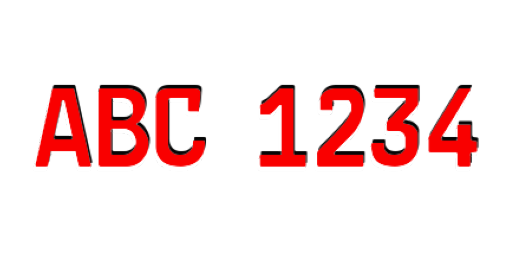


Text with Random Chipping and Emboss Applied


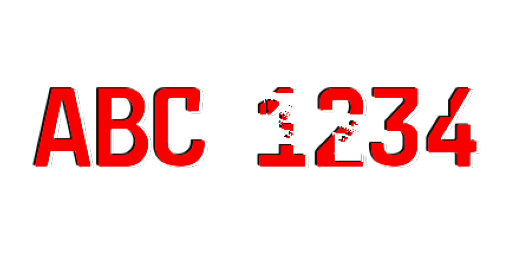

In [70]:
# Demo: Emboss Effect on Text Layer

print("Emboss Effect Demo")

# Create a sample text layer
sample_text = create_text_layer(
    fonts[0],
    "ABC 1234",
    maw,
    mah,
    v_red,
    enable_paint_chipping=False
)

# Apply emboss effect
embossed_text = apply_random_emboss(sample_text["image"])

print("\nText with Random Emboss Applied")
plot_image(embossed_text)

# Create a sample text layer
sample_text = create_text_layer(
    fonts[0],
    "ABC 1234",
    maw,
    mah,
    v_red,
    enable_paint_chipping=True
)

# Apply emboss effect
chipped_and_embossed_text = apply_random_emboss(sample_text["image"])

print("\nText with Random Chipping and Emboss Applied")
plot_image(chipped_and_embossed_text)

In [ ]:
# Let's also sample our dummy text generator
print("dummy text samples:")
for _ in range(3):
    print(generate_dummy_text())

dummy text samples:
P58CN 0VT WCJG
UU2PA ECELU OX9Z
MOSI PLM 686U


## Plate Templates

Using the images aboved as reference, below are four templates for plate generation, namely
- vehicle plates
- motorcycle plates
- beveled motorcycle plates
- rizal plates

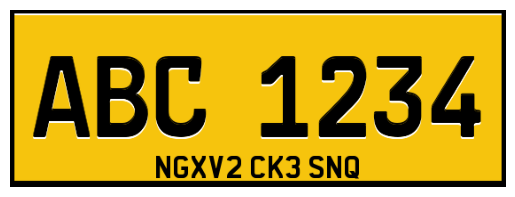

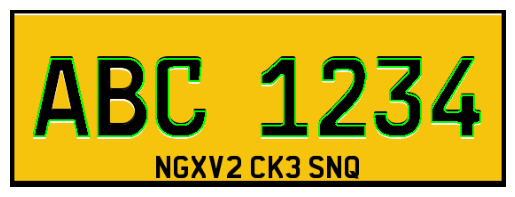

In [83]:
def create_vehicle_plate(color1, color2, font, text,
                         enable_paint_chipping=False,
                         enable_small_text=True):

    base = create_plate_base(vw, vh, color1, color2, border_thickness=0, has_bevel=False)

    content_layer = Image.new("RGBA", (vw, vh), (0, 0, 0, 0))
    d = ImageDraw.Draw(content_layer)

    for i in range(5):
        d.rectangle([i, i, vw - 1 - i, vh - 1 - i], outline=color1 + (255,))

    text_out = create_text_layer(
        font, text, vw, vh, color1,
        enable_paint_chipping=enable_paint_chipping
    )
    content_layer = Image.alpha_composite(content_layer, text_out["image"])

    content_layer = apply_random_emboss(content_layer)
    plate = Image.alpha_composite(base, content_layer)

    if enable_small_text:
        plate = add_small_text(
            plate,
            generate_dummy_text(),
            position="bottom",
            color=color1
        )

    return {"image": plate, "annotations": text_out["annotations"]}

sample_plate = create_vehicle_plate(black, v_yellow, fonts[0], "ABC 1234")
plot_image(sample_plate["image"])
plot_image(visualize_polygon_overlay(sample_plate["image"], sample_plate["annotations"]))

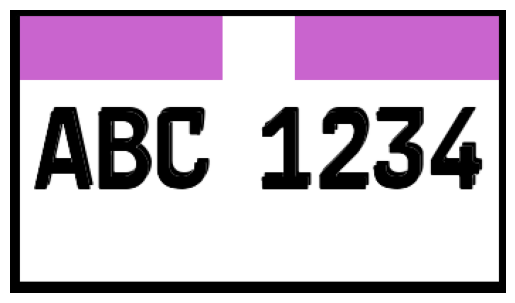

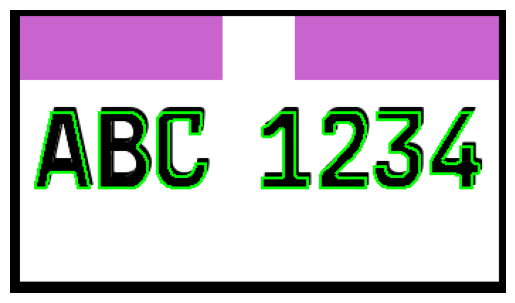

In [85]:
def create_motorcycle_plate(color, font, text,
                            detailOnTop=True,
                            enable_paint_chipping=False):

    base = create_plate_base(mw, mh, black, white, border_thickness=0, has_bevel=False)

    content_layer = Image.new("RGBA", (mw, mh), (0, 0, 0, 0))
    d = ImageDraw.Draw(content_layer)

    for i in range(5):
        d.rectangle([i, i, mw - 1 - i, mh - 1 - i], outline=black + (255,))

    text_out = create_text_layer(
        font, text, mw, mh, black,
        enable_paint_chipping=enable_paint_chipping
    )
    content_layer = Image.alpha_composite(content_layer, text_out["image"])
    content_layer = apply_random_emboss(content_layer)

    plate = Image.alpha_composite(base, content_layer)

    rect_w, rect_h = int(72 * debug_scale), int(22 * debug_scale)
    offset = 5
    detail_layer = Image.new("RGBA", (mw, mh), (0, 0, 0, 0))
    dd = ImageDraw.Draw(detail_layer)

    if detailOnTop:
        dd.rectangle([offset, offset, offset + rect_w, offset + rect_h], fill=color + (255,))
        dd.rectangle([mw - offset - rect_w, offset, mw - offset, offset + rect_h], fill=color + (255,))
    else:
        dd.rectangle([offset, mh - offset - rect_h, offset + rect_w, mh - offset], fill=color + (255,))
        dd.rectangle([mw - offset - rect_w, mh - offset - rect_h, mw - offset, mh - offset], fill=color + (255,))

    plate = Image.alpha_composite(plate, ImageChops.darker(detail_layer, plate))

    return {"image": plate, "annotations": text_out["annotations"]}


sample_plate = create_motorcycle_plate(m_pink, fonts[0], "ABC 1234")
plot_image(sample_plate["image"])
plot_image(visualize_polygon_overlay(sample_plate["image"], sample_plate["annotations"]))

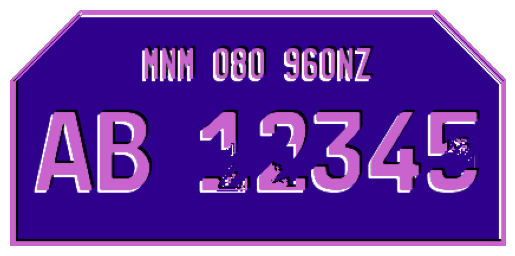

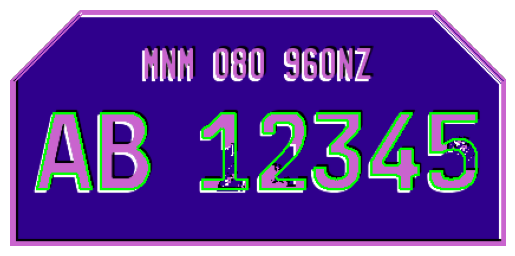

In [ ]:
def create_motorcycle_beveled_plate(color1, color2, font, text,
                                    enable_paint_chipping=False,
                                    enable_small_text=True):

    base = create_plate_base(maw, mah, color1, color2, border_thickness=0, has_bevel=True)
    content_layer = Image.new("RGBA", (maw, mah), (0, 0, 0, 0))
    d = ImageDraw.Draw(content_layer)

    for i in range(5):
        shift = int(i * (math.sqrt(2) - 1))
        poly = [
            (i, corner + shift),
            (corner + shift, i),
            (maw - corner - shift, i),
            (maw - i, corner + shift),
            (maw - i, mah - i),
            (i, mah - i)
        ]
        d.polygon(poly, outline=color1 + (255,))

    text_out = create_text_layer(
        font, text, maw, mah, color1,
        enable_paint_chipping=enable_paint_chipping
    )

    shift_y = int(mah * 0.1)
    shifted_image = Image.new("RGBA", (maw, mah), (0, 0, 0, 0))
    shifted_image.paste(text_out["image"], (0, shift_y), text_out["image"])

    shifted_annotations = []
    for ann in text_out["annotations"]:
        m = Image.new("L", (maw, mah), 0)
        m.paste(ann["mask"], (0, shift_y), ann["mask"])
        shifted_annotations.append({"character": ann["character"], "mask": m})

    text_out["image"] = shifted_image
    text_out["annotations"] = shifted_annotations

    content_layer = Image.alpha_composite(content_layer, shifted_image)
    content_layer = apply_random_emboss(content_layer)

    base_alpha = base.split()[-1]
    content_alpha = content_layer.split()[-1]
    content_layer.putalpha(ImageChops.multiply(content_alpha, base_alpha))

    plate = Image.alpha_composite(base, content_layer)

    if enable_small_text:
        plate = add_small_text(
            plate,
            generate_dummy_text(),
            position="top",
            color=color1
        )

    return {"image": plate, "annotations": text_out["annotations"]}


sample_plate = create_motorcycle_beveled_plate(
    m_pink, m_dark_blue, fonts[0], "AB 12345",
    enable_paint_chipping=True)
plot_image(sample_plate["image"])
plot_image(visualize_polygon_overlay(sample_plate["image"], sample_plate["annotations"]))

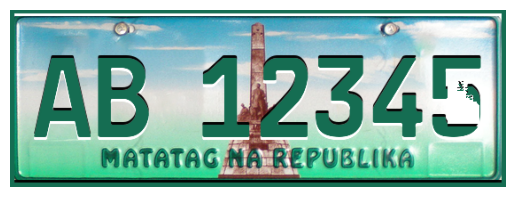

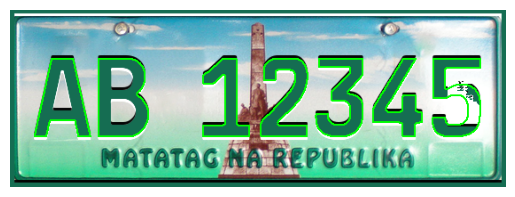

In [87]:
def create_rizal_plate(font, text, enable_paint_chipping=False):
    base = Image.open(r_background).convert("RGBA").resize((vw, vh), Image.Resampling.LANCZOS)

    content_layer = Image.new("RGBA", (vw, vh), (0, 0, 0, 0))
    d = ImageDraw.Draw(content_layer)

    for i in range(5):
        d.rectangle([i, i, vw - 1 - i, vh - 1 - i], outline=r_green + (255,))

    text_out = create_text_layer(
        font, text, vw, vh, r_green,
        enable_paint_chipping=enable_paint_chipping
    )

    content_layer = Image.alpha_composite(content_layer, text_out["image"])
    content_layer = apply_random_emboss(content_layer)

    plate = Image.alpha_composite(base, content_layer)
    return {"image": plate, "annotations": text_out["annotations"]}


sample_plate = create_rizal_plate(
    fonts[0], "AB 12345",
    enable_paint_chipping=True)
plot_image(sample_plate["image"])
plot_image(visualize_polygon_overlay(sample_plate["image"], sample_plate["annotations"]))

## Plate Obscurations
### Let's add one more layer of obscuration. So that the model doesn't overfit on "clean" license plates, I've prepared plate-level obscurations as well.

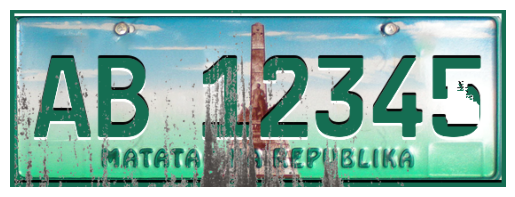

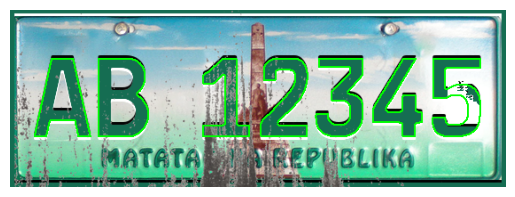

In [91]:
plate_obscurations_dir = os.path.join(images_dir, "obscurations_plate")
plate_obscuration_files = [
    os.path.join(plate_obscurations_dir, f)
    for f in os.listdir(plate_obscurations_dir)
    if f.lower().endswith((".png", ".jpg"))
]

def apply_plate_obscuration(plate_image):
    if not plate_obscuration_files:
        return plate_image
    
    # Convert to RGBA if needed
    if plate_image.mode != "RGBA":
        plate_image = plate_image.convert("RGBA")
    
    # Randomly select an obscuration
    obscuration_path = random.choice(plate_obscuration_files)
    obscuration = Image.open(obscuration_path).convert("RGBA")
    
    # Resize obscuration to match plate dimensions
    obscuration = obscuration.resize(plate_image.size, Image.Resampling.LANCZOS)
    
    # Get the alpha channel of the plate to use as a mask
    plate_alpha = plate_image.split()[3]
    
    # Apply the plate's alpha mask to the obscuration
    # This ensures obscuration only appears on opaque pixels
    r, g, b, a = obscuration.split()
    # Multiply obscuration alpha with plate alpha
    masked_alpha = ImageChops.multiply(a, plate_alpha)
    obscuration_masked = Image.merge("RGBA", (r, g, b, masked_alpha))
    
    # Composite the masked obscuration on top of the plate
    result = Image.alpha_composite(plate_image, obscuration_masked)
    
    return result

# example using the plate above.
plate_img_obscured = apply_plate_obscuration(sample_plate["image"])
plot_image(plate_img_obscured)
plot_image(visualize_polygon_overlay(plate_img_obscured, sample_plate["annotations"]))

## Plate Augmentations
While I'll also perform augmentations during the training loop, manually augmenting the raw dataset (especially for rotation, affining, and motion blur) will help control these parameters.

The first method is for placing our augmented plates onto a 512x12 background.

In [ ]:
# Background images used for plate placement
plate_backgrounds_dir = os.path.join(images_dir, "image_backgrounds")

plate_background_files = [
    os.path.join(plate_backgrounds_dir, f)
    for f in os.listdir(plate_backgrounds_dir)
    if f.lower().endswith((".png", ".jpg"))
]

def plate_on_512x512(plate_image, annotations, scale=1.0, enable_random_background=False):
    target_size = (512, 512)

    if enable_random_background:
        bg_file = random.choice(plate_background_files)
        background = Image.open(bg_file).convert("RGBA").resize(
            target_size, Image.Resampling.LANCZOS
        )
    else:
        background = Image.new("RGBA", target_size, (0, 0, 0, 0))

    max_plate_w = int(target_size[0] * 0.8 * scale)
    max_plate_h = int(target_size[1] * 0.4 * scale)

    plate_w, plate_h = plate_image.size
    scale_factor = min(
        max_plate_w / plate_w,
        max_plate_h / plate_h,
        1.0
    )

    new_w = int(plate_w * scale_factor)
    new_h = int(plate_h * scale_factor)

    plate_resized = plate_image.resize((new_w, new_h), Image.Resampling.LANCZOS)

    pos_x = random.randint(0, target_size[0] - new_w)
    pos_y = random.randint(0, target_size[1] - new_h)

    result = background.copy()
    result.paste(plate_resized, (pos_x, pos_y), plate_resized)

    transformed_annotations = []
    for ann in annotations:
        resized_mask = ann["mask"].resize((new_w, new_h), Image.Resampling.LANCZOS)
        mask_canvas = Image.new("L", target_size, 0)
        mask_canvas.paste(resized_mask, (pos_x, pos_y))
        transformed_annotations.append({
            "character": ann["character"],
            "mask": mask_canvas
        })

    return {"image": result, "annotations": transformed_annotations}


For Perspective:

In [ ]:
def perspective_transform(image, annotations, max_warp=0):
    width, height = image.size
    img_array = np.array(image)

    max_displacement = int(max(max_warp * width, max_warp * height))
    canvas_width = width + 2 * max_displacement
    canvas_height = height + 2 * max_displacement

    original_points = np.float32([
        [max_displacement, max_displacement],
        [width + max_displacement, max_displacement],
        [width + max_displacement, height + max_displacement],
        [max_displacement, height + max_displacement]
    ])

    def perturb_point(x, y):
        return [
            x + random.uniform(-max_warp * width, max_warp * width),
            y + random.uniform(-max_warp * height, max_warp * height)
        ]

    new_points = np.float32([
        perturb_point(*original_points[0]),
        perturb_point(*original_points[1]),
        perturb_point(*original_points[2]),
        perturb_point(*original_points[3])
    ])

    matrix = cv2.getPerspectiveTransform(original_points, new_points)

    channels = img_array.shape[2]
    canvas = np.zeros((canvas_height, canvas_width, channels), dtype=np.uint8)
    canvas[
        max_displacement:max_displacement + height,
        max_displacement:max_displacement + width
    ] = img_array

    warped_image = cv2.warpPerspective(
        canvas,
        matrix,
        (canvas_width, canvas_height),
        flags=cv2.INTER_LINEAR,
        borderMode=cv2.BORDER_CONSTANT,
        borderValue=(0, 0, 0, 0)
    )

    warped_annotations = []
    for ann in annotations:
        mask = np.array(ann["mask"])
        mask_canvas = np.zeros((canvas_height, canvas_width), dtype=np.uint8)
        mask_canvas[
            max_displacement:max_displacement + height,
            max_displacement:max_displacement + width
        ] = mask

        warped_mask = cv2.warpPerspective(
            mask_canvas,
            matrix,
            (canvas_width, canvas_height),
            flags=cv2.INTER_LINEAR,
            borderMode=cv2.BORDER_CONSTANT,
            borderValue=0
        )

        warped_annotations.append({
            "character": ann["character"],
            "mask": Image.fromarray(warped_mask)
        })

    return {"image": Image.fromarray(warped_image), "annotations": warped_annotations}

print("Perspective Warp")

out = perspective_transform(
    sample_plate["image"],
    sample_plate["annotations"],
    max_warp=0.2
)

out = plate_on_512x512(out["image"], out["annotations"], scale=1.0)
plot_image(visualize_polygon_overlay(out["image"], out["annotations"]))


For rotation:

In [94]:
def rotate_transform(image, annotations, max_angle=0):
    angle = random.uniform(-max_angle, max_angle)

    rotated_image = image.rotate(
        angle,
        expand=True,
        resample=Image.Resampling.BICUBIC,
        fillcolor=(0, 0, 0, 0)
    )

    rotated_annotations = []
    for ann in annotations:
        rotated_mask = ann["mask"].rotate(
            angle,
            expand=True,
            resample=Image.Resampling.BICUBIC,
            fillcolor=0
        )
        rotated_annotations.append({
            "character": ann["character"],
            "mask": rotated_mask
        })

    return {"image": rotated_image, "annotations": rotated_annotations}


For motion blur:

In [95]:
def motion_blur(image, annotations, length=20, angle=0, num_samples=10):
    img_array = np.array(image)
    height, width = img_array.shape[:2]

    angle_rad = np.deg2rad(angle)
    dx = (length * np.cos(angle_rad)) / num_samples
    dy = (length * np.sin(angle_rad)) / num_samples

    accumulated = np.zeros_like(img_array, dtype=np.float32)

    for i in range(num_samples):
        tx = dx * (i - num_samples // 2)
        ty = dy * (i - num_samples // 2)
        M = np.float32([[1, 0, tx], [0, 1, ty]])
        shifted = cv2.warpAffine(
            img_array.astype(np.float32),
            M,
            (width, height)
        )
        accumulated += shifted

    result = (accumulated / num_samples).astype(np.uint8)

    return {"image": Image.fromarray(result), "annotations": annotations}


For placing onto a 512x512 canvas: